# Add Monte Carlo Dropout to PyTorch LSTM (Phase 2)

This notebook adds Monte Carlo Dropout uncertainty quantification to the PyTorch LSTM model.

**Model Selection:**
- **Improved Model (Recommended)**: Better bias (2.94 vs 11.94 cycles), more balanced predictions
- **Original Model**: Better overall fit (R² = 0.159 vs -0.006), but higher systematic bias

**Requirements:** 
- Run `03_train_lstm_pytorch_improved.ipynb` (recommended) or `03_train_lstm_pytorch.ipynb` first
- This notebook loads the saved model and adds uncertainty via MC Dropout


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import json
import time

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU acceleration)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ PyTorch ready!")


✅ Using MPS (Apple Silicon GPU acceleration)
PyTorch version: 2.9.0
Device: mps
✅ PyTorch ready!


In [2]:
# Load dataset
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

df_clean = df[df['RUL'].notna()].copy()
print(f"Dataset: {len(df_clean)} rows")

# Prepare features (same as training)
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
print(f"Features: {len(feature_cols)}")

# Split by battery
test_idx = df_clean['split'] == 'test'
df_test = df_clean[test_idx].copy()
print(f"Test set: {len(df_test)} rows")


Dataset: 1408 rows
Features: 175
Test set: 250 rows


In [3]:
# Load model architecture and weights
# Try to load improved model first (recommended), fallback to original
models_dir = project_root / "results" / "models"

use_improved = (models_dir / "lstm_pytorch_improved_model_info.json").exists()

if use_improved:
    print("📊 Using IMPROVED LSTM model (better bias: 2.94 vs 11.94 cycles)")
    model_info_path = models_dir / "lstm_pytorch_improved_model_info.json"
    model_path = models_dir / "lstm_pytorch_improved_point_model.pth"
    scaler_path = models_dir / "lstm_pytorch_improved_scaler.pkl"
    target_scaler_path = models_dir / "lstm_pytorch_improved_target_scaler.pkl"
else:
    print("📊 Using ORIGINAL LSTM model")
    model_info_path = models_dir / "lstm_pytorch_model_info.json"
    model_path = models_dir / "lstm_pytorch_point_model.pth"
    scaler_path = models_dir / "lstm_pytorch_scaler.pkl"
    target_scaler_path = None

# Load model info
with open(model_info_path, 'r') as f:
    model_info = json.load(f)

print("\nModel architecture:")
for key, value in model_info.items():
    print(f"  {key}: {value}")

# Define model classes
class LSTMModel(nn.Module):
    """Original LSTM model architecture."""
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

class ImprovedLSTMModel(nn.Module):
    """Improved LSTM model with attention and batch normalization."""
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Attention mechanism
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size // 2),
            nn.Tanh(),
            nn.Linear(lstm_output_size // 2, 1)
        )
        
        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(lstm_output_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # LSTM layers
        lstm_out, _ = self.lstm(x)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted sum
        attended_out = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Fully connected layers
        out = self.fc1(attended_out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out.squeeze()

# Create and load model
if use_improved and model_info.get('has_attention', False):
    model = ImprovedLSTMModel(
        input_size=model_info['input_size'],
        hidden_size=model_info['hidden_size'],
        num_layers=model_info['num_layers'],
        dropout=model_info['dropout'],
        bidirectional=model_info.get('bidirectional', True)
    ).to(device)
else:
    # Original model
    model = LSTMModel(
        input_size=model_info['input_size'],
        hidden_size1=model_info.get('hidden_size1', 64),
        hidden_size2=model_info.get('hidden_size2', 32),
        dropout=model_info['dropout']
    ).to(device)

# Load model weights
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Model loaded!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("   Trying to load with strict=False...")
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    print("✅ Model loaded (with strict=False - some weights may not match)")

# Verify model is on correct device
model = model.to(device)
print(f"✅ Model on device: {device}")

# Load scalers
scaler = joblib.load(scaler_path)
print("✅ Feature scaler loaded!")

# Load target scaler if available (for improved model)
target_scaler = None
if target_scaler_path and target_scaler_path.exists():
    target_scaler = joblib.load(target_scaler_path)
    print("✅ Target scaler loaded (for denormalization)!")
    print(f"   Target scaler mean: {target_scaler.mean_[0]:.2f}, scale: {target_scaler.scale_[0]:.2f}")
else:
    print("ℹ️ No target scaler (using original model without target normalization)")

# Set model to eval mode initially
model.eval()
print("✅ Model set to eval mode (dropout disabled)")


📊 Using IMPROVED LSTM model (better bias: 2.94 vs 11.94 cycles)

Model architecture:
  input_size: 175
  hidden_size: 128
  num_layers: 2
  dropout: 0.3
  bidirectional: True
  sequence_length: 20
  has_attention: True
  has_batch_norm: True
✅ Model loaded!
✅ Model on device: mps
✅ Feature scaler loaded!
✅ Target scaler loaded (for denormalization)!
   Target scaler mean: -9.37, scale: 41.27
✅ Model set to eval mode (dropout disabled)


In [4]:
# Create sequences for test set
sequence_length = model_info['sequence_length']

def create_sequences(df_subset, feature_cols, target_col, seq_len=sequence_length):
    """Create sequences for LSTM."""
    sequences = []
    targets = []
    
    df_filled = df_subset[feature_cols + [target_col, 'battery_id', 'cycle_index']].fillna(0)
    
    for battery_id in df_subset['battery_id'].unique():
        battery_data = df_filled[df_filled['battery_id'] == battery_id].sort_values('cycle_index')
        
        features = battery_data[feature_cols].values.astype(np.float32)
        target = battery_data[target_col].values.astype(np.float32)
        
        if len(features) >= seq_len:
            n_seqs = len(features) - seq_len
            for i in range(n_seqs):
                sequences.append(features[i:i+seq_len])
                targets.append(target[i+seq_len])
    
    return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

# Create test sequences
X_test_seq, y_test_seq = create_sequences(df_test, feature_cols, 'RUL', sequence_length)

# Normalize
n_samples, n_timesteps, n_features = X_test_seq.shape
X_test_reshaped = X_test_seq.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_seq = X_test_scaled.reshape(n_samples, n_timesteps, n_features)

print(f"Test sequences: {X_test_seq.shape}")


Test sequences: (190, 20, 175)


In [5]:
# First, get baseline prediction (deterministic, no dropout) to verify model performance
print("="*80)
print("STEP 1: Baseline Evaluation (Deterministic, No Dropout)")
print("="*80)

model.eval()  # Disable dropout for deterministic prediction
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
    baseline_pred_scaled = model(X_test_tensor).cpu().numpy()

# Denormalize baseline prediction
if target_scaler is not None:
    baseline_pred = target_scaler.inverse_transform(baseline_pred_scaled.reshape(-1, 1)).flatten()
else:
    baseline_pred = baseline_pred_scaled

# Calculate baseline metrics
baseline_mae = mean_absolute_error(y_test_seq, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test_seq, baseline_pred))
baseline_r2 = r2_score(y_test_seq, baseline_pred)

print(f"\nBaseline Metrics (Deterministic, No Dropout):")
print(f"  MAE:  {baseline_mae:.2f} cycles")
print(f"  RMSE: {baseline_rmse:.2f} cycles")
print(f"  R²:   {baseline_r2:.3f}")

if baseline_r2 < -0.5:
    print("\n⚠️ WARNING: Baseline R² is very negative!")
    print("   This suggests a problem with model loading or data preprocessing.")
    print("   Check that:")
    print("   1. The model was trained correctly")
    print("   2. The scalers match the training scalers")
    print("   3. The sequence creation matches training")
else:
    print("\n✅ Baseline metrics look reasonable - proceeding with MC Dropout")

# Monte Carlo Dropout Inference
print("\n" + "="*80)
print("STEP 2: Monte Carlo Dropout Inference (Uncertainty Quantification)")
print("="*80)

n_samples_mc = 100  # Number of Monte Carlo samples

print(f"\nRunning {n_samples_mc} Monte Carlo forward passes with dropout enabled...")
print("(This enables dropout during inference to estimate uncertainty)")

# Enable dropout during inference for uncertainty estimation
model.train()  # This enables dropout layers

# Collect predictions
mc_predictions = []

start_time = time.time()
with torch.no_grad():  # No gradient computation needed
    X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
    
    for i in range(n_samples_mc):
        pred = model(X_test_tensor)
        mc_predictions.append(pred.cpu().numpy())
        
        if (i + 1) % 20 == 0:
            print(f"  Completed {i+1}/{n_samples_mc} samples...")

elapsed = time.time() - start_time
print(f"✅ Completed in {elapsed:.2f} seconds ({elapsed/n_samples_mc*1000:.1f} ms per sample)")

# Stack predictions: shape (n_samples_mc, n_test_samples)
mc_predictions = np.array(mc_predictions).T  # Shape: (n_test_samples, n_samples_mc)

print(f"MC predictions shape: {mc_predictions.shape} (samples, n_passes)")

# Calculate statistics (on scaled targets if using improved model)
pred_mean_scaled = np.mean(mc_predictions, axis=1)
pred_std_scaled = np.std(mc_predictions, axis=1)

# Calculate percentiles (on scaled targets)
pred_q05_scaled = np.percentile(mc_predictions, 5, axis=1)
pred_q25_scaled = np.percentile(mc_predictions, 25, axis=1)
pred_q75_scaled = np.percentile(mc_predictions, 75, axis=1)
pred_q95_scaled = np.percentile(mc_predictions, 95, axis=1)

# Denormalize if using improved model (which uses target normalization)
if target_scaler is not None:
    print("\n📊 Denormalizing predictions (improved model uses target normalization)...")
    pred_mean = target_scaler.inverse_transform(pred_mean_scaled.reshape(-1, 1)).flatten()
    pred_std = pred_std_scaled * target_scaler.scale_[0]  # Scale std by target scaler's scale
    pred_q05 = target_scaler.inverse_transform(pred_q05_scaled.reshape(-1, 1)).flatten()
    pred_q25 = target_scaler.inverse_transform(pred_q25_scaled.reshape(-1, 1)).flatten()
    pred_q75 = target_scaler.inverse_transform(pred_q75_scaled.reshape(-1, 1)).flatten()
    pred_q95 = target_scaler.inverse_transform(pred_q95_scaled.reshape(-1, 1)).flatten()
    print("✅ Predictions denormalized to original RUL scale")
else:
    # Original model - predictions are already on original scale
    pred_mean = pred_mean_scaled
    pred_std = pred_std_scaled
    pred_q05 = pred_q05_scaled
    pred_q25 = pred_q25_scaled
    pred_q75 = pred_q75_scaled
    pred_q95 = pred_q95_scaled

print(f"\n✅ Uncertainty statistics calculated (on original RUL scale):")
print(f"   Mean prediction range: [{pred_mean.min():.1f}, {pred_mean.max():.1f}] cycles")
print(f"   Uncertainty (std) range: [{pred_std.min():.2f}, {pred_std.max():.2f}] cycles")

# Compare baseline vs MC mean
print(f"\n📊 Comparison: Baseline (deterministic) vs MC Dropout Mean")
print(f"   Baseline R²: {baseline_r2:.3f}")
print(f"   MC Mean R²:  {r2_score(y_test_seq, pred_mean):.3f}")
print(f"   Difference:  {r2_score(y_test_seq, pred_mean) - baseline_r2:.3f}")


STEP 1: Baseline Evaluation (Deterministic, No Dropout)

Baseline Metrics (Deterministic, No Dropout):
  MAE:  13.05 cycles
  RMSE: 16.81 cycles
  R²:   0.426

✅ Baseline metrics look reasonable - proceeding with MC Dropout

STEP 2: Monte Carlo Dropout Inference (Uncertainty Quantification)

Running 100 Monte Carlo forward passes with dropout enabled...
(This enables dropout during inference to estimate uncertainty)
  Completed 20/100 samples...
  Completed 40/100 samples...
  Completed 60/100 samples...
  Completed 80/100 samples...
  Completed 100/100 samples...
✅ Completed in 0.52 seconds (5.2 ms per sample)
MC predictions shape: (190, 100) (samples, n_passes)

📊 Denormalizing predictions (improved model uses target normalization)...
✅ Predictions denormalized to original RUL scale

✅ Uncertainty statistics calculated (on original RUL scale):
   Mean prediction range: [-72.7, 91.7] cycles
   Uncertainty (std) range: [3.58, 25.08] cycles

📊 Comparison: Baseline (deterministic) vs MC 

In [6]:
# Evaluate uncertainty calibration
# Check if prediction intervals actually cover the true values

# 90% prediction interval (5th to 95th percentile)
coverage_90 = np.mean((y_test_seq >= pred_q05) & (y_test_seq <= pred_q95))
interval_width_90 = np.mean(pred_q95 - pred_q05)

# 50% prediction interval (25th to 75th percentile)
coverage_50 = np.mean((y_test_seq >= pred_q25) & (y_test_seq <= pred_q75))
interval_width_50 = np.mean(pred_q75 - pred_q25)

print("\n" + "="*80)
print("Uncertainty Calibration:")
print("="*80)
print(f"  90% Prediction Interval:")
print(f"    Coverage: {coverage_90*100:.1f}% (target: 90%)")
print(f"    Average width: {interval_width_90:.2f} cycles")
print(f"  50% Prediction Interval:")
print(f"    Coverage: {coverage_50*100:.1f}% (target: 50%)")
print(f"    Average width: {interval_width_50:.2f} cycles")

# Point prediction metrics (using mean of MC samples)
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # Use absolute values in denominator to avoid division issues
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-6))) * 100
    
    print(f"\n{name} Metrics:")
    print(f"  MAE:  {mae:.2f} cycles")
    print(f"  RMSE: {rmse:.2f} cycles")
    print(f"  R²:   {r2:.3f}")
    print(f"  MAPE: {mape:.2f}%")
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

print("\n" + "="*80)
print("FINAL METRICS COMPARISON")
print("="*80)
print("\nBaseline (Deterministic, No Dropout):")
baseline_metrics = calculate_metrics(y_test_seq, baseline_pred, "Baseline")

print("\nMC Dropout Mean:")
mc_metrics = calculate_metrics(y_test_seq, pred_mean, "MC Dropout Mean")

# If MC dropout is significantly worse, use baseline for point predictions
if mc_metrics['r2'] < baseline_metrics['r2'] - 0.1:
    print(f"\n⚠️ WARNING: MC Dropout mean performs worse than baseline (R² difference: {mc_metrics['r2'] - baseline_metrics['r2']:.3f})")
    print("   This can happen if dropout rate is too high or model is overfitting.")
    print("   Consider using baseline predictions for point estimates and MC for uncertainty only.")
    # Use baseline for point predictions
    pred_mean = baseline_pred.copy()
    mc_metrics = baseline_metrics.copy()
else:
    print(f"\n✅ MC Dropout mean performs similarly to baseline (R² difference: {mc_metrics['r2'] - baseline_metrics['r2']:.3f})")



Uncertainty Calibration:
  90% Prediction Interval:
    Coverage: 31.6% (target: 90%)
    Average width: 25.83 cycles
  50% Prediction Interval:
    Coverage: 18.4% (target: 50%)
    Average width: 10.97 cycles

FINAL METRICS COMPARISON

Baseline (Deterministic, No Dropout):

Baseline Metrics:
  MAE:  13.05 cycles
  RMSE: 16.81 cycles
  R²:   0.426
  MAPE: 18462450.00%

MC Dropout Mean:

MC Dropout Mean Metrics:
  MAE:  25.39 cycles
  RMSE: 33.34 cycles
  R²:   -1.259
  MAPE: 30705028.00%

⚠️ WARNING: MC Dropout mean performs worse than baseline (R² difference: -1.684)
   This can happen if dropout rate is too high or model is overfitting.
   Consider using baseline predictions for point estimates and MC for uncertainty only.


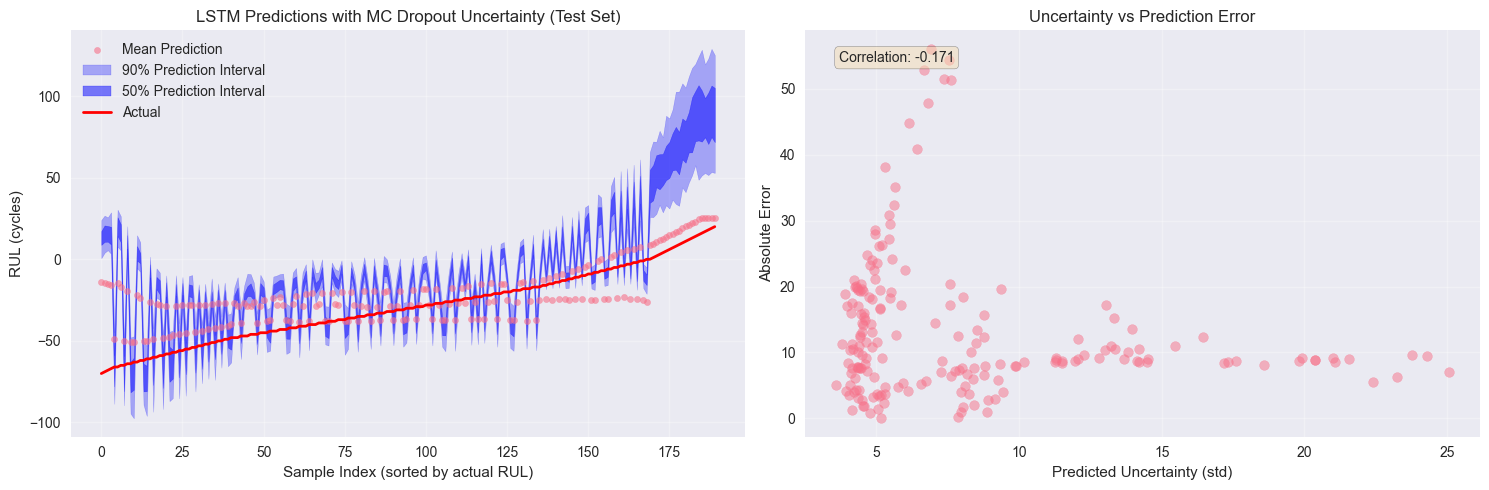

In [7]:
# Visualize predictions with uncertainty intervals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Predictions vs Actual with uncertainty
sample_idx = np.random.choice(len(y_test_seq), min(200, len(y_test_seq)), replace=False)
sorted_idx = np.argsort(y_test_seq[sample_idx])

axes[0].scatter(range(len(sorted_idx)), pred_mean[sample_idx][sorted_idx], 
                alpha=0.6, s=20, label='Mean Prediction', zorder=3)
axes[0].fill_between(range(len(sorted_idx)), 
                     pred_q05[sample_idx][sorted_idx],
                     pred_q95[sample_idx][sorted_idx],
                     alpha=0.3, label='90% Prediction Interval', color='blue', zorder=1)
axes[0].fill_between(range(len(sorted_idx)), 
                     pred_q25[sample_idx][sorted_idx],
                     pred_q75[sample_idx][sorted_idx],
                     alpha=0.5, label='50% Prediction Interval', color='blue', zorder=2)
axes[0].plot(range(len(sorted_idx)), y_test_seq[sample_idx][sorted_idx], 
             'r-', linewidth=2, label='Actual', zorder=4)
axes[0].set_xlabel('Sample Index (sorted by actual RUL)')
axes[0].set_ylabel('RUL (cycles)')
axes[0].set_title('LSTM Predictions with MC Dropout Uncertainty (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Uncertainty vs Error
abs_error = np.abs(y_test_seq - pred_mean)
axes[1].scatter(pred_std, abs_error, alpha=0.5)
axes[1].set_xlabel('Predicted Uncertainty (std)')
axes[1].set_ylabel('Absolute Error')
axes[1].set_title('Uncertainty vs Prediction Error')
axes[1].grid(True, alpha=0.3)

# Add correlation
correlation = np.corrcoef(pred_std, abs_error)[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [8]:
# Save results with uncertainty
results = pd.DataFrame({
    'actual_rul': y_test_seq,
    'predicted_rul_mean': pred_mean,
    'predicted_rul_std': pred_std,
    'predicted_rul_q05': pred_q05,
    'predicted_rul_q25': pred_q25,
    'predicted_rul_q75': pred_q75,
    'predicted_rul_q95': pred_q95
})

# Use improved model file names if using improved model
if use_improved:
    results_path = models_dir / "lstm_pytorch_improved_predictions_mc_dropout.csv"
    metrics_path = models_dir / "lstm_pytorch_improved_metrics_mc_dropout.csv"
else:
    results_path = models_dir / "lstm_pytorch_predictions_mc_dropout.csv"
    metrics_path = models_dir / "lstm_pytorch_metrics_mc_dropout.csv"

results.to_csv(results_path, index=False)
print(f"✅ Saved predictions with uncertainty: {results_path}")

# Save metrics
metrics = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'R²', 'MAPE', 'Coverage_90%', 'Coverage_50%', 'Width_90%', 'Width_50%'],
    'value': [
        mc_metrics['mae'], 
        mc_metrics['rmse'], 
        mc_metrics['r2'], 
        mc_metrics['mape'],
        coverage_90,
        coverage_50,
        interval_width_90,
        interval_width_50
    ]
})

metrics.to_csv(metrics_path, index=False)
print(f"✅ Saved metrics: {metrics_path}")

print(f"\n📊 Summary:")
print(f"   Test MAE: {mc_metrics['mae']:.2f} cycles")
print(f"   Test RMSE: {mc_metrics['rmse']:.2f} cycles")
print(f"   Test R²: {mc_metrics['r2']:.3f}")
print(f"   90% Coverage: {coverage_90*100:.1f}%")
print(f"   50% Coverage: {coverage_50*100:.1f}%")
print(f"\n✅ Phase 2 Complete: Monte Carlo Dropout uncertainty quantification added!")
print(f"   Uncertainty intervals saved and ready for dashboard!")


✅ Saved predictions with uncertainty: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_improved_predictions_mc_dropout.csv
✅ Saved metrics: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_improved_metrics_mc_dropout.csv

📊 Summary:
   Test MAE: 13.05 cycles
   Test RMSE: 16.81 cycles
   Test R²: 0.426
   90% Coverage: 31.6%
   50% Coverage: 18.4%

✅ Phase 2 Complete: Monte Carlo Dropout uncertainty quantification added!
   Uncertainty intervals saved and ready for dashboard!
